In [1]:
%load_ext autoreload
%autoreload 2

import geopandas as gpd
import matplotlib.pyplot as plt 
import jax.numpy as jnp
from jax import random
from numpyro.infer import Predictive
from reusable.util import load_samples, gen_file_name, get_decoder_params, load_args, load_training_state, save_samples, load_training_history
from reusable.gp import BuildGP
from reusable.mcmc import vae_mcmc, run_mcmc
from reusable.geo import get_temp_data
from plotting.plots import plot_draws, compare_draws, plot_one_inference
from plotting.ny import plot_multi_on_state, plot_on_state, mask_for_plotting
import numpyro

numpyro.set_host_device_count(4)


In [2]:
args = load_args(19, 1, 4)
rng_key = random.PRNGKey(3)
if "n" not in args:
    args["n"] = args["x"].shape[0]

    
rng_key, rng_key_init, rng_key_init_state, rng_key_plots = random.split(rng_key, 4)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
import pyreadr
import pandas

df= pandas.DataFrame({"y_obs": args["ground_truth_y_obs"], "obs_idx": args["obs_idx"]})
pyreadr.write_rds(f"data/state_{args['state']}_{args['year']}_{args['aggr_method']}_observations.rds", df)

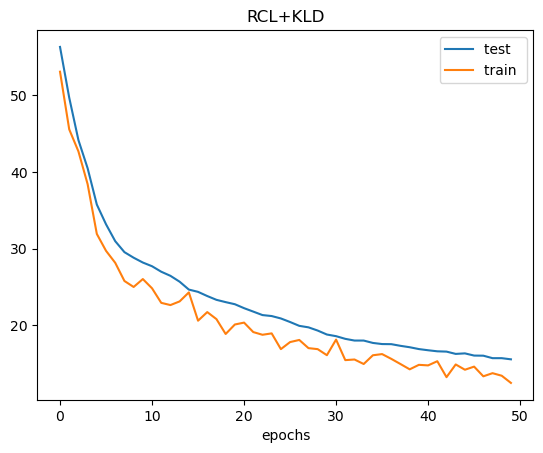

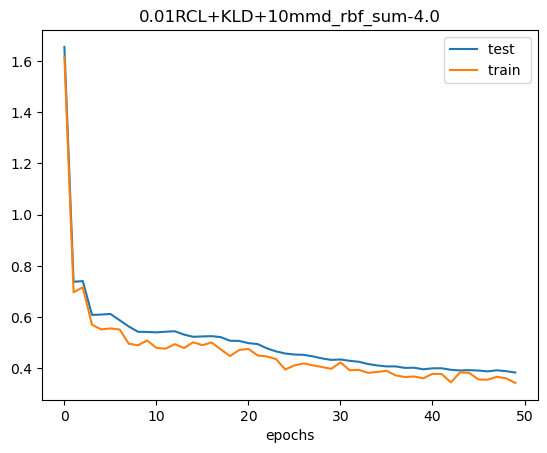

In [4]:
from plotting.plots import plot_training



for loss_fn in args["loss_fn_names"]:
    if loss_fn == "gp":
        continue
    try:
        metrics_hist = load_training_history(args["expcode"], gen_file_name(args["expcode"], args, loss_fn))
        plot_training(metrics_hist["test_loss"], metrics_hist["train_loss"], loss_fn)
    
    except FileNotFoundError:
        continue


## Comparing GP to PriorVAE draws

In [6]:
should_load_samples = False
to_plot = 200

data_file_name = gen_file_name(args["expcode"], args, f"gp_plot_{to_plot}", data_only=True)

if should_load_samples:
    gp_plot_samples = load_samples(19, data_file_name)
else:
    
    gp = BuildGP(
            args["gp_kernel"],
            noise=False,
            length_prior_choice=args["length_prior_choice"],
            length_prior_args=args["length_prior_arguments"],
            variance_prior_choice=args["variance_prior_choice"],
            variance_prior_args=args["variance_prior_arguments"],
        )

    print("Starting GP")

    gp_plot_pred = Predictive(gp, num_samples=to_plot)
    gp_plot_samples = gp_plot_pred(rng_key_plots, args["x"], jitter=5e-5)

    print("Done GP")
    save_samples(args["expcode"], data_file_name , gp_plot_samples)

Mean 10.5 Variance 21.0
Starting GP
Done GP
Saved learnt_models/19/19__1794_400_200_2_invgamma_4.0~1.0_gamma_5.25~0.5__gp_plot_200.samples


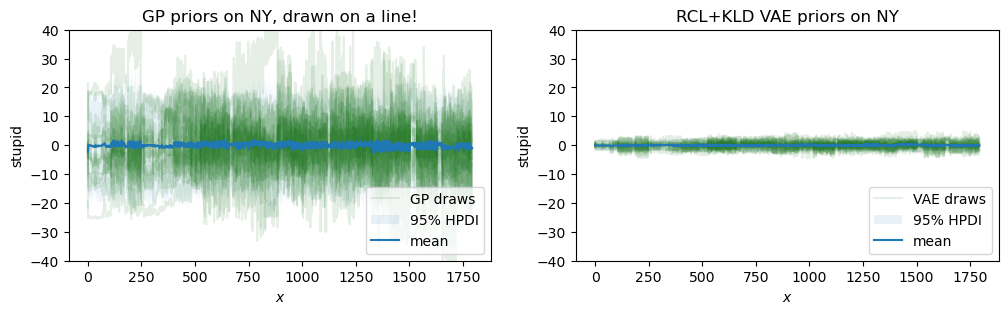

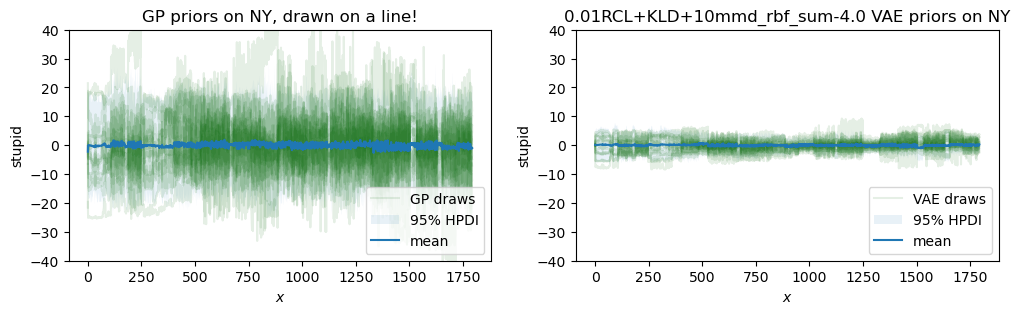

In [8]:
from plotting.plots import compare_draws
from reusable.vae import VAE
import optax
from reusable.train_nn import SimpleTrainState

module = VAE(
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["x"].shape[0],
    conditional=True,
)
params = module.init(rng_key_init, jnp.ones((args["batch_size"], args["n"],)))[
    "params"
]  # initialize parameters by passing a template image
tx = optax.adam(args["learning_rate"])
dummy_state = SimpleTrainState.create(apply_fn=module.apply, params=params, tx=tx, key=rng_key_init_state)

samples = {}

for loss_fn in args["loss_fn_names"]:
    if loss_fn == "gp":
        continue
    file_name = gen_file_name(args["expcode"], args, loss_fn)

    decoder_params = get_decoder_params(load_training_state(args["expcode"], file_name, dummy_state))   

    vae=vae_mcmc(
            args["hidden_dim1"],
            args["hidden_dim2"],
            args["latent_dim"],
            decoder_params,
            obs_idx=None,
            noise=False,
        )

    

    cvae_plot_pred = Predictive(vae, num_samples=to_plot)
    samples[loss_fn] = cvae_plot_pred(rng_key_plots, args["x"], jitter=5e-5)
    compare_draws(
        jnp.arange(0, args["x"].shape[0]),
        gp_plot_samples["y"],
        samples[loss_fn]["f"],
        "GP priors on NY, drawn on a line!",
        f"{loss_fn} VAE priors on NY",
        "stupid",
        "stupid",
        "GP",
        "VAE",
        _min=-40,
        _max=40
    )

(2, 4)
(8, 1794)
(2, 4)
(8, 1794)
(2, 4)


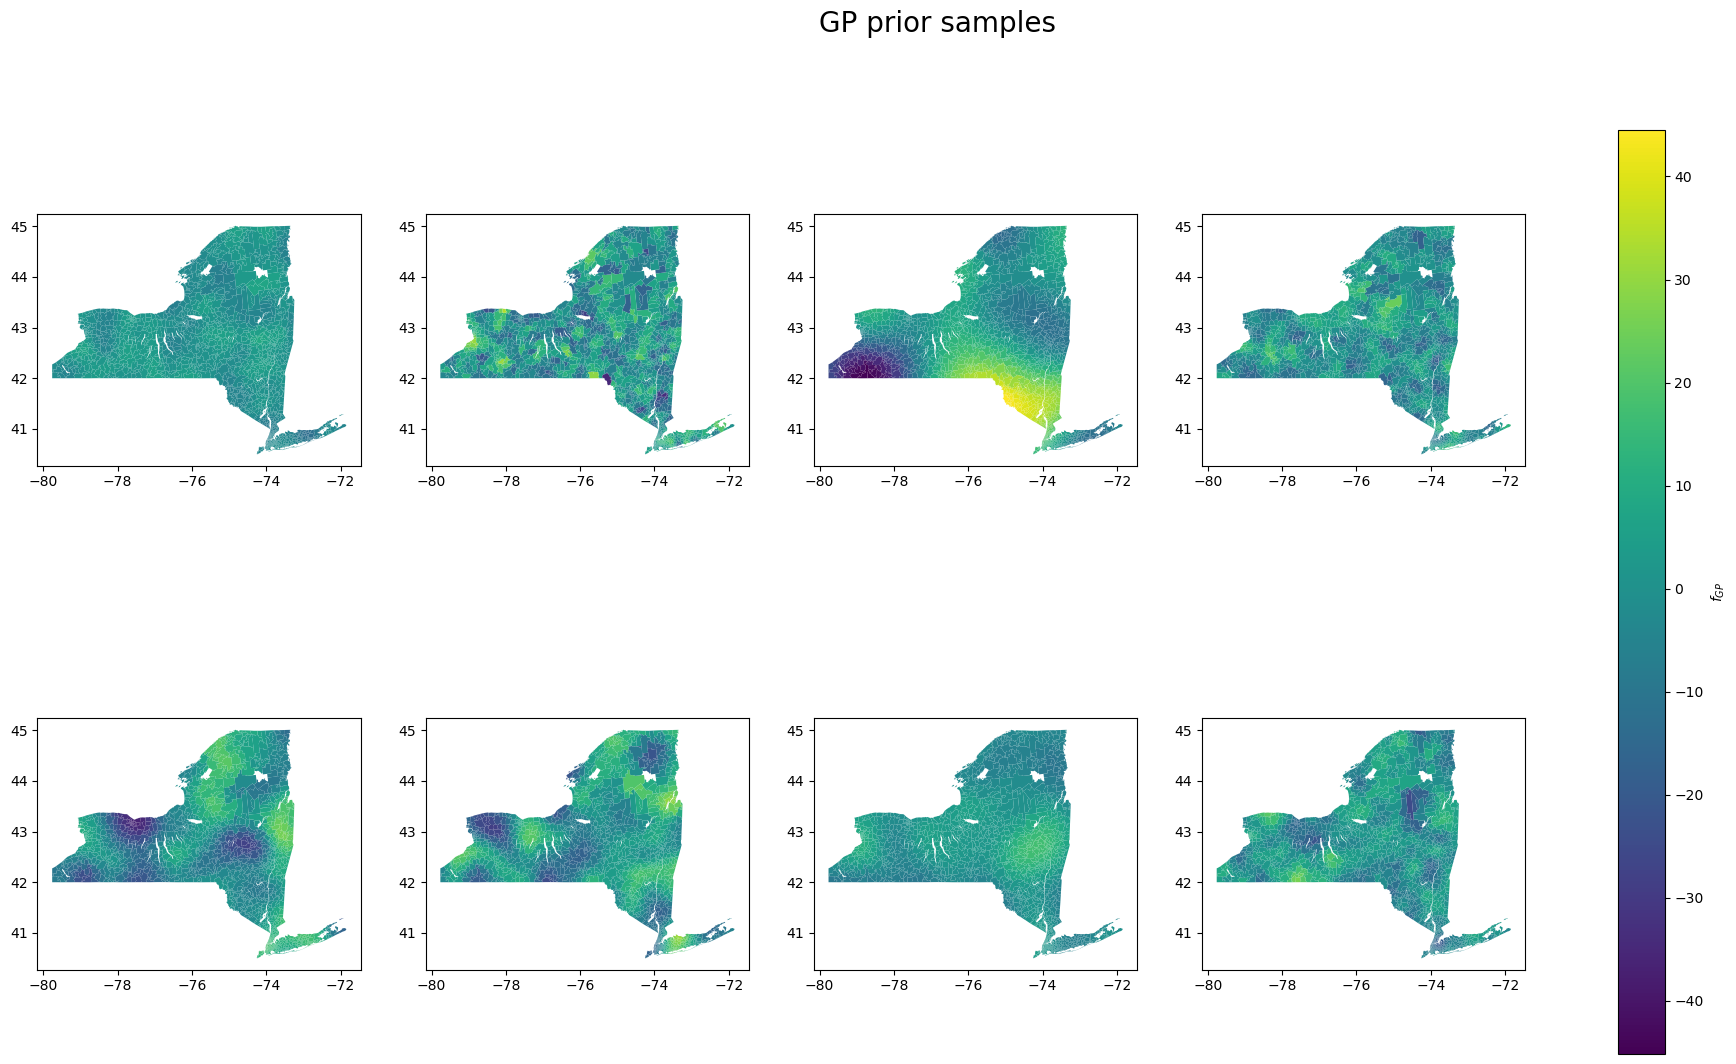

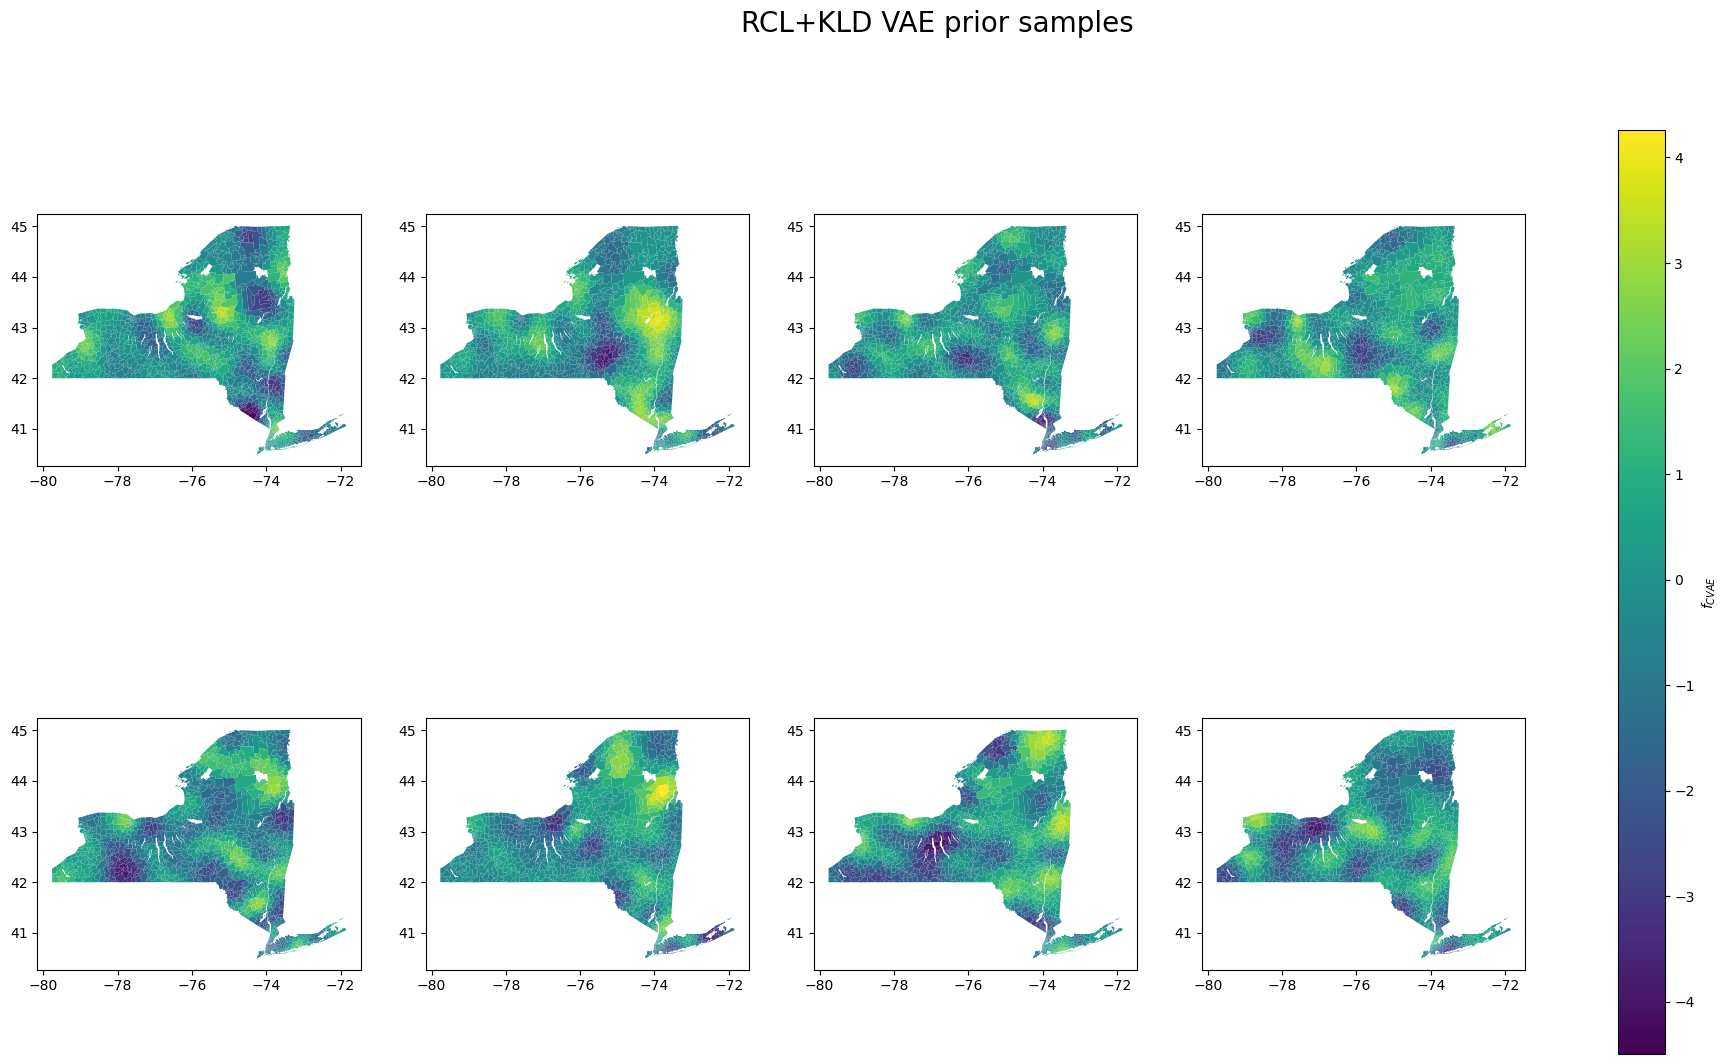

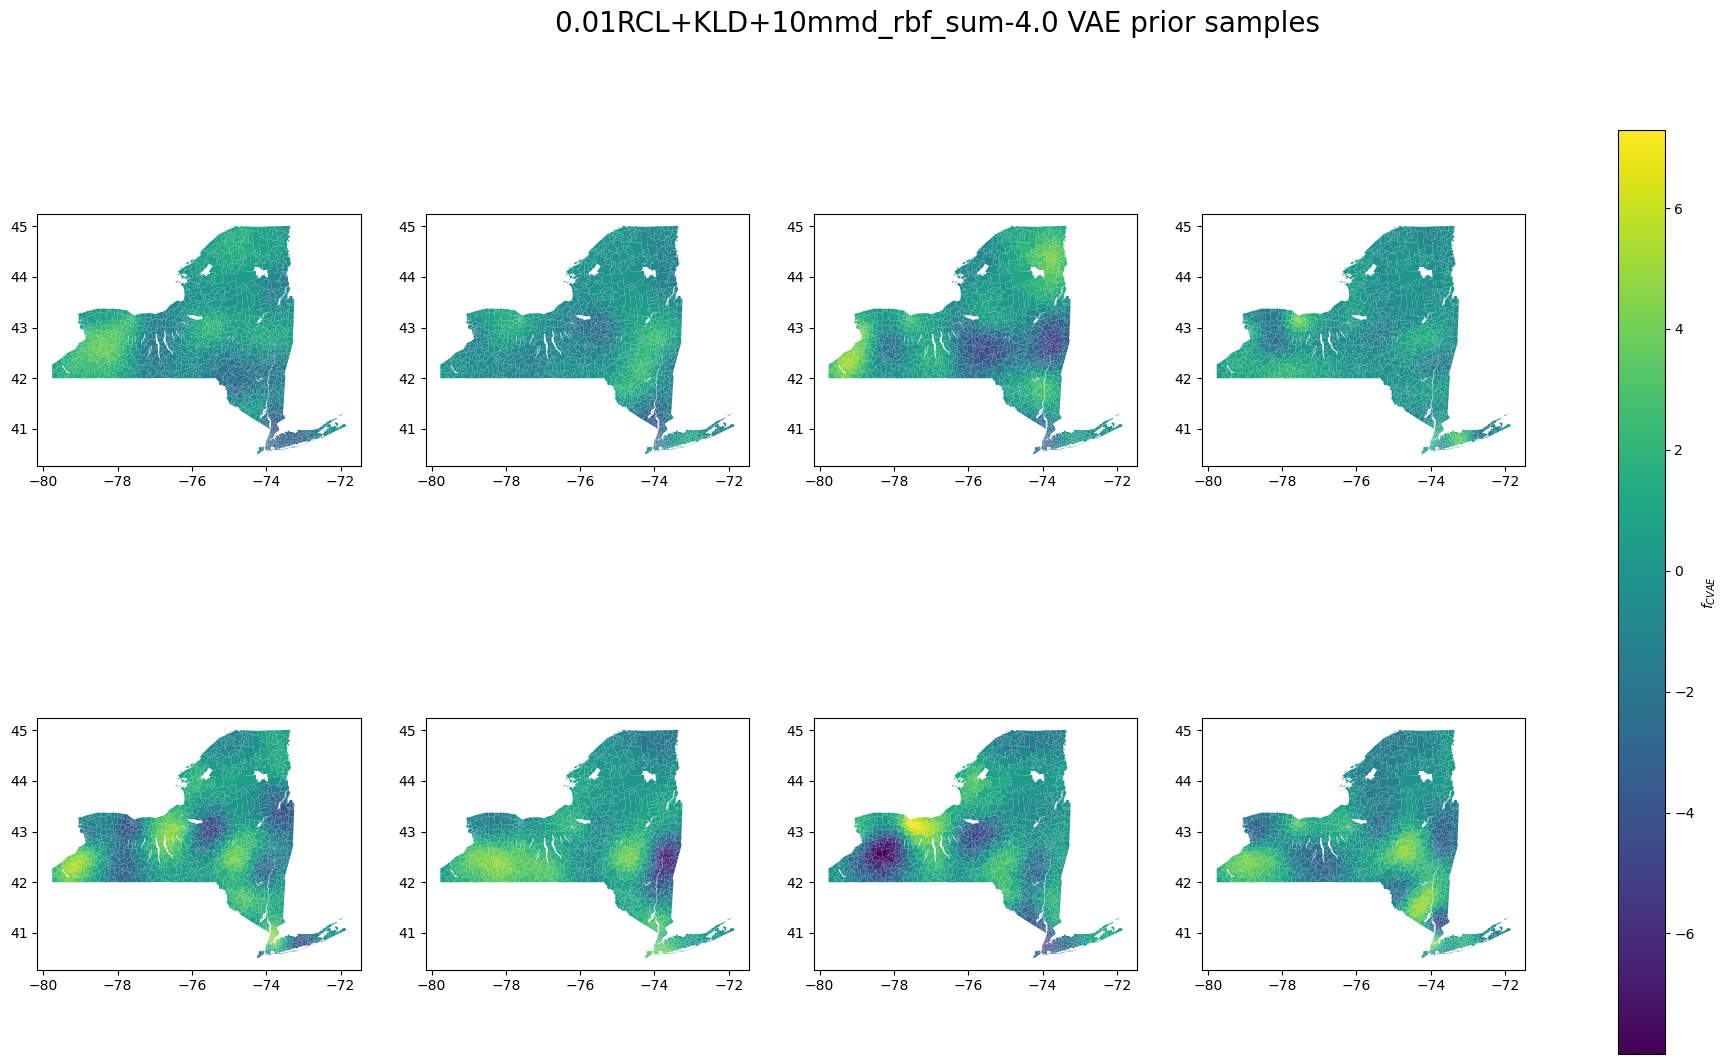

In [10]:
plot_multi_on_state(gp_plot_samples["y"][:8], args["state"], "GP prior samples", "$f_{GP}$")

for loss_fn in args["loss_fn_names"]:
    if loss_fn == "gp":
        continue
    print(samples[loss_fn]["f"][:8].shape)
    plot_multi_on_state(samples[loss_fn]["f"][:8], args["state"], f"{loss_fn} VAE prior samples", "$f_{CVAE}$")


### Ground truth

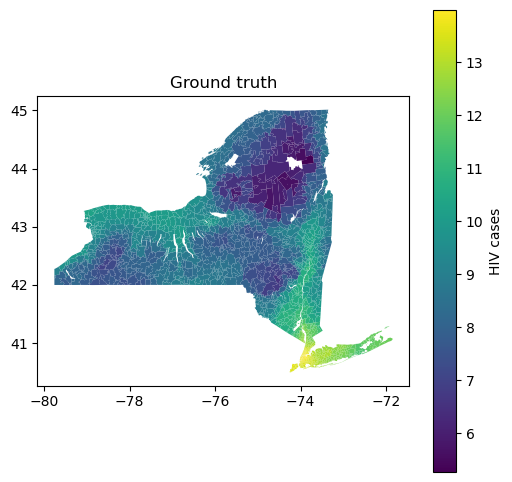

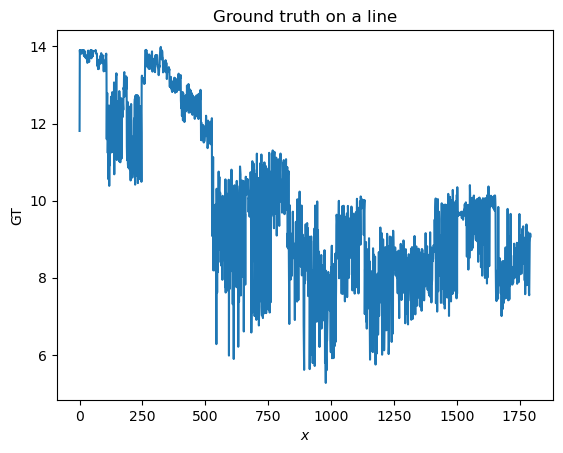

In [11]:
plot_on_state(args["ground_truth"], args["state"], "Ground truth", "HIV cases")
plot_draws(args["ground_truth"][None], jnp.arange(args["n"]), "Ground truth on a line", "GT")

## Masked ground truth

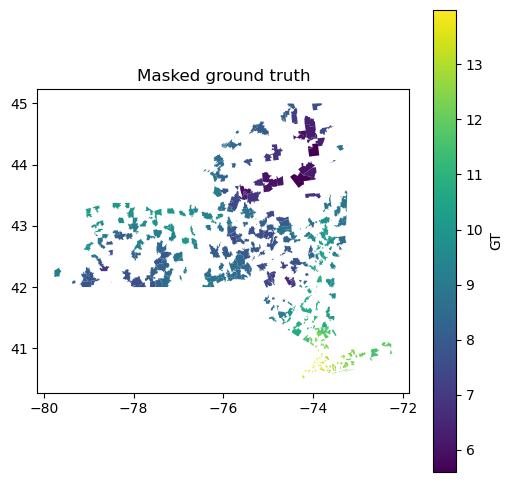

In [12]:
plot_on_state(mask_for_plotting(args["ground_truth"], args["obs_idx"]), args["state"], "Masked ground truth", "GT")


### Inference

In [13]:
vaes = {}


for loss_fn in args["loss_fn_names"]:
    if loss_fn == "gp":
        continue
    gen_file_name(args["expcode"], args, "gp" if loss_fn is None else loss_fn)
    decoder_params = get_decoder_params(load_training_state(args["expcode"], file_name, dummy_state))

    vaes[loss_fn] = vae_mcmc(
            args["hidden_dim1"],
            args["hidden_dim2"],
            args["latent_dim"],
            decoder_params,
            obs_idx=args["obs_idx"],
            noise=True,
        )

In [14]:
rng_key = random.PRNGKey(2345678)

load_mcmc = True

mcmc_samples = {}

for loss_fn in args["loss_fn_names"]:
    if loss_fn == "gp":
        continue

    if load_mcmc:
        mcmc_samples[loss_fn] = load_samples(args["expcode"], gen_file_name(args["expcode"], args, f"inference_{loss_fn}_mcmc", include_mcmc=True))
    
    else:


        rng_key, rng_key_mcmc = random.split(rng_key, 2)

        mcmc_samples[loss_fn] = run_mcmc(
            args["num_warmup"],
            4000, #args["num_samples"],
            args["num_chains"],
            rng_key_mcmc,
            vaes[loss_fn],
            {"x": args["x"],
            "y": args["ground_truth_y_obs"]},
            verbose=True,
            max_run_length=None
        )

    

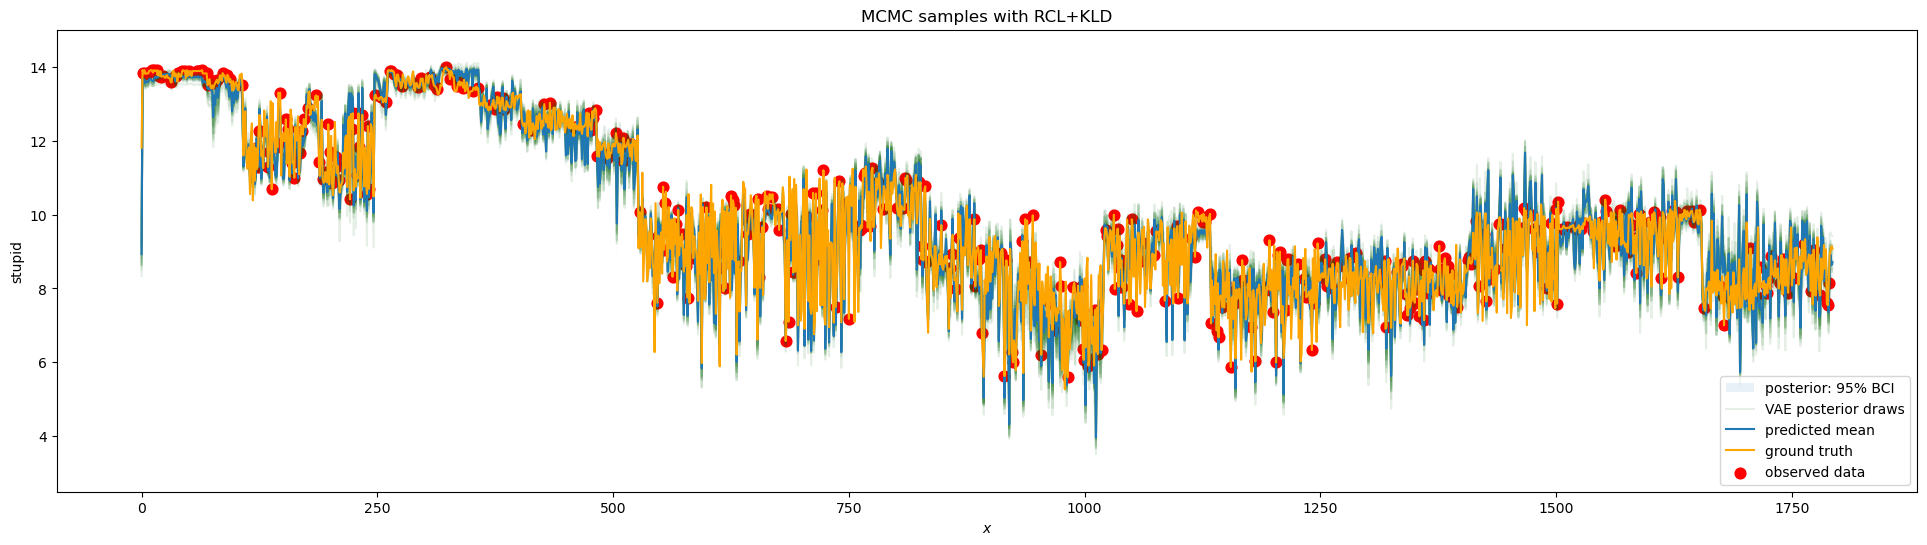

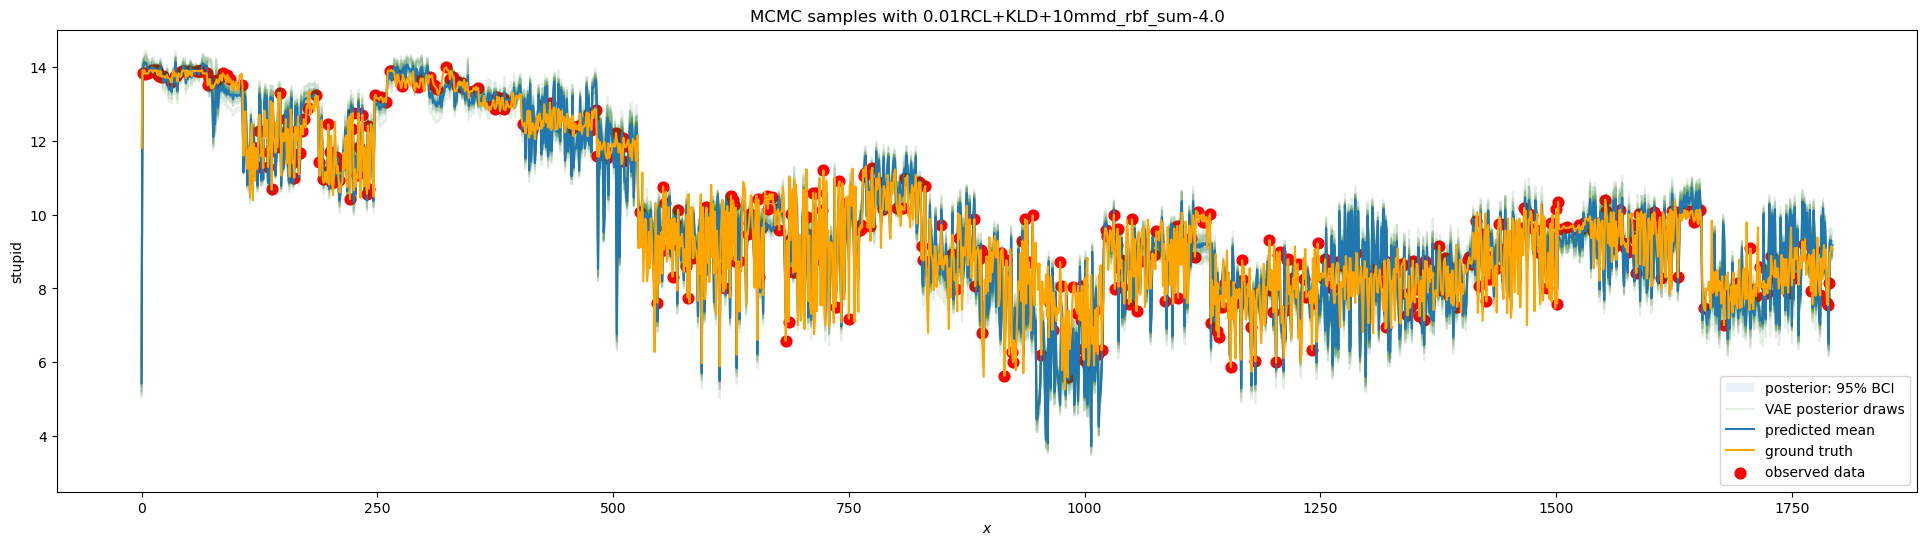

In [33]:
for loss_fn in args["loss_fn_names"]:
    if loss_fn == "gp":
        continue

    fig = plt.figure(figsize=(24, 6))
    ax = fig.add_subplot()

    plot_one_inference(
        mcmc_samples[loss_fn]["f"],
        jnp.arange(0, args["x"].shape[0]),
        args["ground_truth"],
        args["obs_idx"],
        args["ground_truth_y_obs"],
        f"MCMC samples with {loss_fn}",
        "stupid",
        "VAE",
        _min=2.5,
        _max=15,
        ax=ax
    )



In [24]:
means = [args["ground_truth"], mask_for_plotting(args["ground_truth"], args["obs_idx"])]
hpdis = []
titles = ["Ground Truth", "observed ground truth"]
for loss_fn in args["loss_fn_names"]:
    if loss_fn == "gp":
        continue

    mean = jnp.mean(mcmc_samples[loss_fn]["f"], axis=0)
    hpdis.append(numpyro.diagnostics.hpdi(mcmc_samples[loss_fn]["f"], 0.95))
    means.append(mean)
    titles.append(loss_fn)

(1, 4)


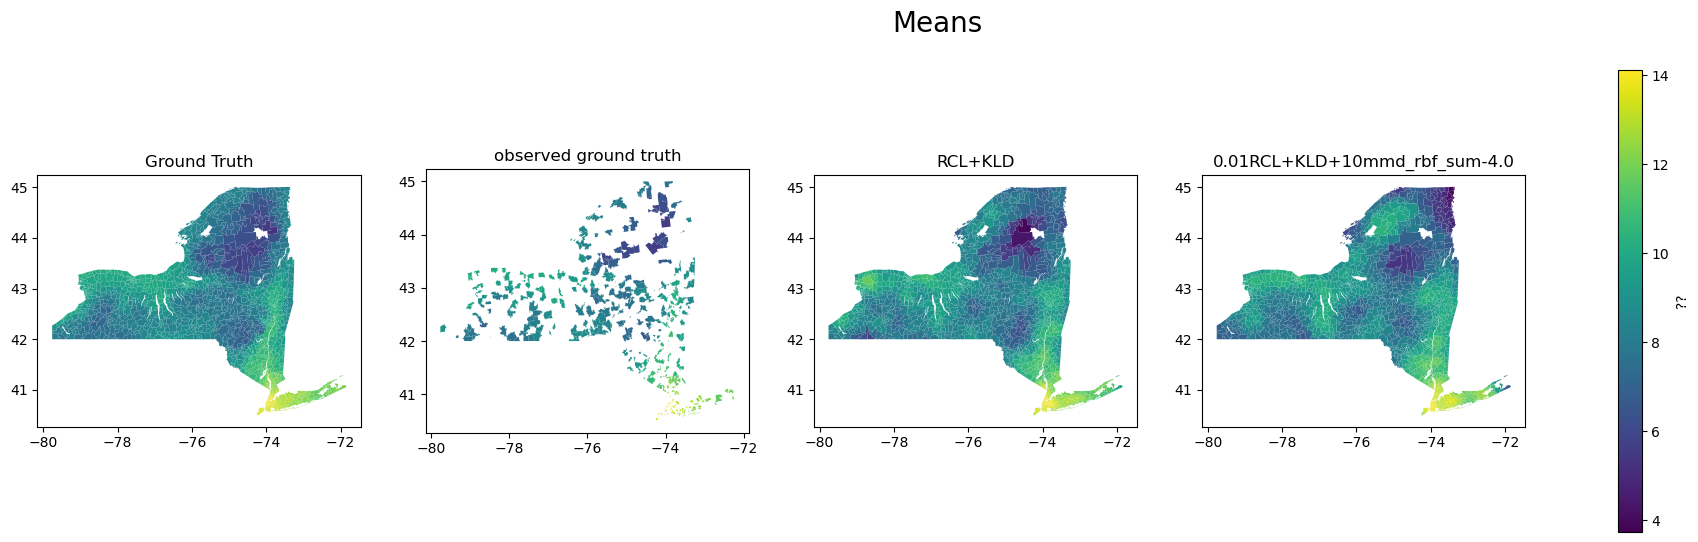

In [21]:
plot_multi_on_state(jnp.array(means), 36, "Means", "??", titles, num_in_row=4)

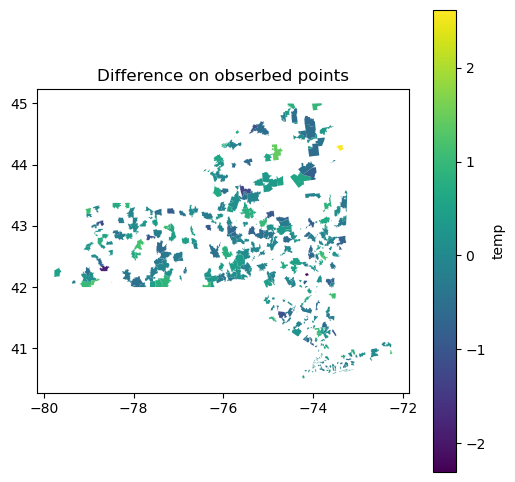

In [22]:
plot_on_state(mask_for_plotting(args["ground_truth"] - means[2], args["obs_idx"]), 36, "Difference on obserbed points", "temp")

In [38]:
import numpy as onp
mask = onp.zeros((args["n"]))
mask[args["obs_idx"]] = 1

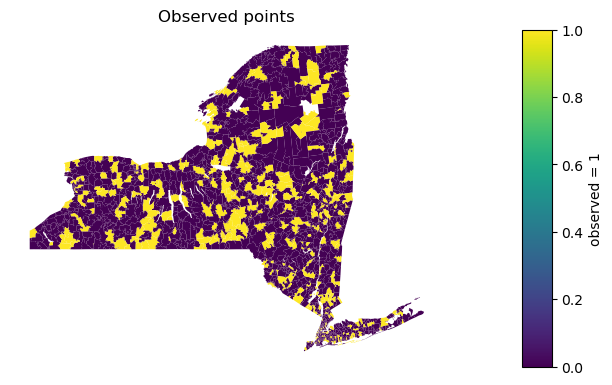

In [53]:
plot_on_state(mask, 36, "Observed points", "observed = 1")

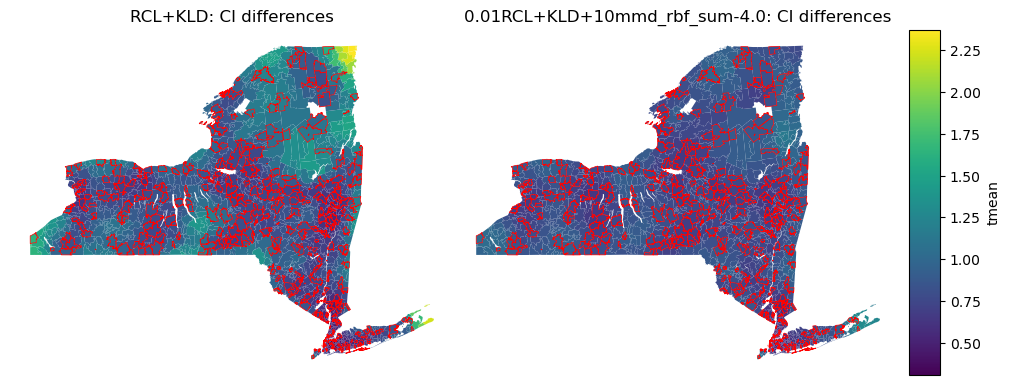

In [54]:

plot_multi_on_state(onp.array([u-l for l,u in hpdis]), 36, "CI comparisons", "tmean",  [f"{x}: CI differences" for x in args["loss_fn_names"][1:]], edge_highlight_indices=args["obs_idx"])